In [1]:
%matplotlib notebook

import folium
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

## Measurement flags: T - Trace of precipitation, snowfall, or snow depth
##                    P - Identified as "missing presumed zero" in DSI 3200 and 3206

## Quality flags: I - Failed internal consistency check

## Source flags: 0 - U.S. Cooperative Summary of the Day (NCDC DSI-3200)
##               6 - CDMP Cooperative Summary of the Day (NCDC DSI-3206)
##               7 - U.S. Cooperative Summary of the Day - Transmitted via WxCoder3 (NCDC DSI-3207)
##               K - U.S. cooperative Summary of the Day data digitized from paper observer forms (from 2011 to present)
##               N - Community Collaborative Rain, Hail, and Snow (CoCoRaHS)
##               W - WBAN/ASOS Summary of the Day from NCDC's Integrated Surface Data (ISD)
##               Z - Datzilla official additions or replacements

## Missing values: 9999 or -9999 depending on documentation

## Reading in and cleaning the snowfall DataFrame

snowfall_by_station = pd.read_csv('weather_station_snowfall_data.csv', header=0, 
                             names=['Station ID', 'Station Name', 'Latitude', 'Longitude', 'Elevation', 'Date', 'Obs Snowfall', 'Flags'],
                             index_col='Date', parse_dates=True)

snowfall_by_station.dropna(inplace=True)

snowfall_by_station['Measurement Flag'] = snowfall_by_station['Flags'].apply(lambda x: x.split(',')[0])
snowfall_by_station['Quality Flag'] = snowfall_by_station['Flags'].apply(lambda x: x.split(',')[1])
snowfall_by_station['Source Flag']  = snowfall_by_station['Flags'].apply(lambda x: x.split(',')[2])

del(snowfall_by_station['Flags'])

num_stations = len(snowfall_by_station['Station ID'].unique())

print('Number of weather stations used: ', num_stations)
#print('DataFrame index dtype: ', snowfall_by_station.index.dtype)
print()
print('Unique Measurement Flags: ', snowfall_by_station['Measurement Flag'].unique())
print('Unique Quality Flags: ', snowfall_by_station['Quality Flag'].unique())
print('Unique Source Flags: ', snowfall_by_station['Source Flag'].unique())
print()
print('Observations with Quality Flag "I:" ', len(snowfall_by_station[snowfall_by_station['Quality Flag'] == 'I']))
print('Observations with Measurement Flag "P:" ', len(snowfall_by_station[snowfall_by_station['Measurement Flag'] == 'P']))
print('Unique Snowfall measurements when Measurement Flag is "P:" ', snowfall_by_station[snowfall_by_station['Measurement Flag'] == 'P']['Obs Snowfall'].unique()) ## Snowfall totals (0 in) are consistent with "presumed zero"
print('Unique Snowfall measurements when Measurement Flag is "T:" ', snowfall_by_station[snowfall_by_station['Measurement Flag'] == 'T']['Obs Snowfall'].unique()) ## Snowfall totals (0 in) are consistent with a trace
print('Entries denoted as missing: ', len(snowfall_by_station[snowfall_by_station['Obs Snowfall'].abs() == 9999]))


snowfall_by_station = snowfall_by_station[snowfall_by_station['Quality Flag'] != 'I']

snowfall_by_station_noP = snowfall_by_station[snowfall_by_station['Measurement Flag'] != 'P'] ## Considering these values are "missing presumed zero," I would rather remove them.
                                                                                              ## Given this is a large portion of the data (~15%), but has no other quality flags,
                                                                                              ## I want to see the difference between including and excluding this data

snowfall_by_station

Number of weather stations used:  30

Unique Measurement Flags:  ['' 'T' 'P']
Unique Quality Flags:  ['' 'I']
Unique Source Flags:  ['6' '0' 'K' 'Z' '7' 'N' 'W']

Observations with Quality Flag "I:"  40
Observations with Measurement Flag "P:"  25773
Unique Snowfall measurements when Measurement Flag is "P:"  [0.]
Unique Snowfall measurements when Measurement Flag is "T:"  [0.]
Entries denoted as missing:  0


,Station ID,Station Name,Latitude,Longitude,Elevation,Obs Snowfall,Measurement Flag,Quality Flag,Source Flag
Date,,,,,,,,,
1900-07-01,USC00119822,"YORKVILLE, IL US",41.6500,-88.4500,182.9,0.0,,,6
1900-07-02,USC00119822,"YORKVILLE, IL US",41.6500,-88.4500,182.9,0.0,,,6
1900-07-03,USC00119822,"YORKVILLE, IL US",41.6500,-88.4500,182.9,0.0,,,6
1900-07-04,USC00119822,"YORKVILLE, IL US",41.6500,-88.4500,182.9,0.0,,,6
1900-07-05,USC00119822,"YORKVILLE, IL US",41.6500,-88.4500,182.9,0.0,,,6
...,...,...,...,...,...,...,...,...,...
2023-06-26,US1ILDP0132,"WHEATON 2.0 NNE, IL US",41.8798,-88.0863,241.4,0.0,,,N
2023-06-27,US1ILDP0132,"WHEATON 2.0 NNE, IL US",41.8798,-88.0863,241.4,0.0,,,N
2023-06-28,US1ILDP0132,"WHEATON 2.0 NNE, IL US",41.8798,-88.0863,241.4,0.0,,,N


In [2]:
## Averaging snowfall totals by date across all available weather stations

def check_mult_daily_obs(group):
    if len(group) > len(group['Station ID'].unique()):
        print(group[['Station ID', 'Obs Snowfall']])
        raise ValueError('One or more weather stations likely reported multiple observations for the same date')

def avg_snowfall_by_date(df_by_station):
    _ = df_by_station.groupby(level=0).apply(check_mult_daily_obs)
    
    df_by_date = df_by_station.groupby(level=0).agg({'Station ID': len, 'Obs Snowfall': np.mean})
    df_by_date.rename(columns={'Station ID': '# Stations', 'Obs Snowfall': 'Avg Snowfall'}, inplace=True)
        
    return df_by_date
    
snowfall_by_date = avg_snowfall_by_date(snowfall_by_station)
snowfall_by_date_noP = avg_snowfall_by_date(snowfall_by_station_noP)

snowfall_by_date

,# Stations,Avg Snowfall
Date,,
1900-07-01,1,0.0
1900-07-02,1,0.0
1900-07-03,1,0.0
1900-07-04,1,0.0
1900-07-05,1,0.0
...,...,...
2023-06-26,14,0.0
2023-06-27,16,0.0
2023-06-28,16,0.0


In [3]:
## Snowfall on leap days

def leap_day_snow(df_by_date):
    return df_by_date[(df_by_date['Avg Snowfall'] > 0.) & (df_by_date.index.month == 2) & (df_by_date.index.day == 29)]

print('Leap days with measureable snow since '+str(min(snowfall_by_date.index).year+1)+': ', len(leap_day_snow(snowfall_by_date)))
print('["P" flagged observations removed] Leap days with measureable snow since '+str(min(snowfall_by_date_noP.index).year+1)+': ', len(leap_day_snow(snowfall_by_date_noP)))
print()
print(leap_day_snow(snowfall_by_date))

snowfall_by_date = snowfall_by_date[~((snowfall_by_date.index.month == 2) & (snowfall_by_date.index.day == 29))]
snowfall_by_date_noP = snowfall_by_date_noP[~((snowfall_by_date_noP.index.month == 2) & (snowfall_by_date_noP.index.day == 29))]

Leap days with measureable snow since 1901:  1
["P" flagged observations removed] Leap days with measureable snow since 1901:  1

            # Stations  Avg Snowfall
Date                                
2008-02-29          15      1.646667


In [4]:
## Summing snowfall totals over a year, where the year extends from July 1 - June 30 in order to capture each winter season in full

def custom_year(date):
    if date.month >= 7:
        return '{}-{}'.format(date.year, date.year+1)
    else:
        return '{}-{}'.format(date.year-1, date.year)
    
    
def total_snowfall_by_year(df_by_date):
    df_by_year = df_by_date.groupby(custom_year).agg({'# Stations': (len, np.mean), 'Avg Snowfall': np.sum})
    df_by_year.rename(columns={'len': 'Days Summed', 'mean': 'Avg # Stations', 'sum': 'Total Snowfall'}, inplace=True)
    df_by_year = df_by_year.droplevel(0, axis=1)
    
    return df_by_year

snowfall_by_year = total_snowfall_by_year(snowfall_by_date)
snowfall_by_year_noP = total_snowfall_by_year(snowfall_by_date_noP)

#print(len(snowfall_by_year))
#print((365*len(snowfall_by_year[snowfall_by_year['Days Summed'] < 365])) - snowfall_by_year[snowfall_by_year['Days Summed'] < 365]['Days Summed'].sum())

snowfall_by_year[snowfall_by_year['Days Summed'] < 365]

,Days Summed,Avg # Stations,Total Snowfall
Date,,,
1900-1901,362,2.262431,35.400000
1911-1912,364,2.653846,40.166667
1919-1920,351,1.000000,32.700000
1930-1931,334,1.000000,10.500000
1932-1933,350,1.000000,22.700000
1978-1979,363,1.746556,70.700000
1986-1987,334,1.634731,15.900000
1987-1988,364,1.917582,39.200000
1990-1991,364,1.912088,19.350000


In [5]:
## According to the National Weather Service, in Chicago the earliest measurable snow (0.1 in or more)
## ever recorded fell on Oct. 12, 2006, and the latest measurable snow ever recorded fell on May 11, 1966.
## Therefore, any years with missing data for days between these dates will be excluded from the set.
## Any years with missing data only outside of these dates will remain.
## I only care about measurable snow, since any "trace" amounts are recorded as zero in this data.

def remove_incomplete_years(df_by_date, df_by_year):

    days = pd.date_range(min(df_by_date.index), max(df_by_date.index), freq='D')
    days = days[~((days.month == 2) & (days.day == 29))]

    missing_dates = pd.to_datetime([date for date in days if date not in df_by_date.index])

    missing_dates = missing_dates[((missing_dates.month == 10) & (missing_dates.day >= 12)) |
                                  ((missing_dates.month == 5)  & (missing_dates.day <= 11)) |
                                  (missing_dates.month > 10) |
                                  (missing_dates.month < 5)]

    removed_years = []

    for month, year in zip(missing_dates.month, missing_dates.year):
        if month < 7:
            year_str = '{}-{}'.format(year-1, year)
        else:
            year_str = '{}-{}'.format(year, year+1)
            
        if year_str not in removed_years:
            df_by_year.drop(index=year_str, inplace=True)
            removed_years.append(year_str)
        
    return df_by_year, missing_dates, removed_years
        
snowfall_by_year_final, md, rm_years = remove_incomplete_years(snowfall_by_date, snowfall_by_year)
snowfall_by_year_final_noP, md_noP, rm_years_noP = remove_incomplete_years(snowfall_by_date_noP, snowfall_by_year_noP)
    
    
# print(md)
# print()
# print(len(snowfall_by_year_final))
# print(len(snowfall_by_year_final_noP))

snowfall_by_year_final

,Days Summed,Avg # Stations,Total Snowfall
Date,,,
1900-1901,362,2.262431,35.400000
1901-1902,365,2.408219,15.950000
1902-1903,365,2.484932,18.533333
1903-1904,365,2.358904,49.366667
1904-1905,365,2.383562,38.600000
...,...,...,...
2018-2019,365,15.084932,46.721214
2019-2020,365,15.178082,36.054364
2020-2021,365,15.391781,39.735137


In [6]:
## Finding yearly snowfall anomalies from the 1900/1901 to 1999/2000 average, calculated with remaining available years

def calc_snowfall_anomalies(df_by_year):
    twentieth_cent_years = sorted([int(year[:4]) for year in df_by_year.index if year[:2] == '19'])
    end_year = '{}-{}'.format(max(twentieth_cent_years), max(twentieth_cent_years)+1)
    twentieth_cent_df = df_by_year.iloc[:df_by_year.index.get_loc(end_year)+1]
    average = twentieth_cent_df['Total Snowfall'].mean()
    anomalies = np.subtract(df_by_year['Total Snowfall'], average)
    
    return average, anomalies, twentieth_cent_df

baseline_average, snowfall_by_year_final['Snowfall Anomalies'], subdir_20c = calc_snowfall_anomalies(snowfall_by_year_final)
baseline_average_noP, snowfall_by_year_final_noP['Snowfall Anomalies'], subdir_20c_noP = calc_snowfall_anomalies(snowfall_by_year_final_noP)

print('Average yearly total snowfall for the 20th century: {:.2f}'.format(baseline_average))
print('(Calculated with available years between {} and {})'.format(subdir_20c.index[0], subdir_20c.index[-1]))
print()
print('["P" flagged observations removed] Average yearly total snowfall for the 20th century: {:.2f}'.format(baseline_average_noP))
print('(Calculated with available years between {} and {})'.format(subdir_20c_noP.index[0], subdir_20c_noP.index[-1]))
# print()
# print(snowfall_by_year_final_noP.index)


snowfall_by_year_final

Average yearly total snowfall for the 20th century: 30.65
(Calculated with available years between 1900-1901 and 1999-2000)

["P" flagged observations removed] Average yearly total snowfall for the 20th century: 30.90
(Calculated with available years between 1900-1901 and 1980-1981)


,Days Summed,Avg # Stations,Total Snowfall,Snowfall Anomalies
Date,,,,
1900-1901,362,2.262431,35.400000,4.752240
1901-1902,365,2.408219,15.950000,-14.697760
1902-1903,365,2.484932,18.533333,-12.114427
1903-1904,365,2.358904,49.366667,18.718907
1904-1905,365,2.383562,38.600000,7.952240
...,...,...,...,...
2018-2019,365,15.084932,46.721214,16.073455
2019-2020,365,15.178082,36.054364,5.406604
2020-2021,365,15.391781,39.735137,9.087377


In [7]:
global_temp_anoms = pd.read_csv('global_avg_temp_anomalies.csv', skiprows=5, names=['Year', 'Temp Anomaly'],
                                 converters={'Temp Anomaly': lambda x: float(x)*9./5.})  ## Converting from delta(C) to delta(F)

global_temp_anoms['Year'] = global_temp_anoms['Year'].apply(lambda x: '{}-{}'.format(x-1, x))
global_temp_anoms.set_index([np.arange(0, 123, 1), 'Year'], inplace=True)

global_temp_anoms_noP = global_temp_anoms.copy()

global_temp_anoms_final = global_temp_anoms.drop(index=rm_years, level=1)
global_temp_anoms_final_noP = global_temp_anoms_noP.drop(index=rm_years_noP, level=1)

removed_years = global_temp_anoms.groupby(level=1).filter(lambda x: x.index.get_level_values(1).values in rm_years)

print(removed_years)

global_temp_anoms_final

              Temp Anomaly
   Year                   
19 1919-1920        -0.486
30 1930-1931        -0.126
32 1932-1933        -0.378
78 1978-1979         0.198
90 1990-1991         0.774
91 1991-1992         0.648
94 1994-1995         0.792


,,Temp Anomaly
,Year,
0,1900-1901,-0.108
1,1901-1902,-0.396
2,1902-1903,-0.432
3,1903-1904,-0.810
4,1904-1905,-0.630
...,...,...
118,2018-2019,1.656
119,2019-2020,1.872
120,2020-2021,1.566


<IPython.core.display.Javascript object>


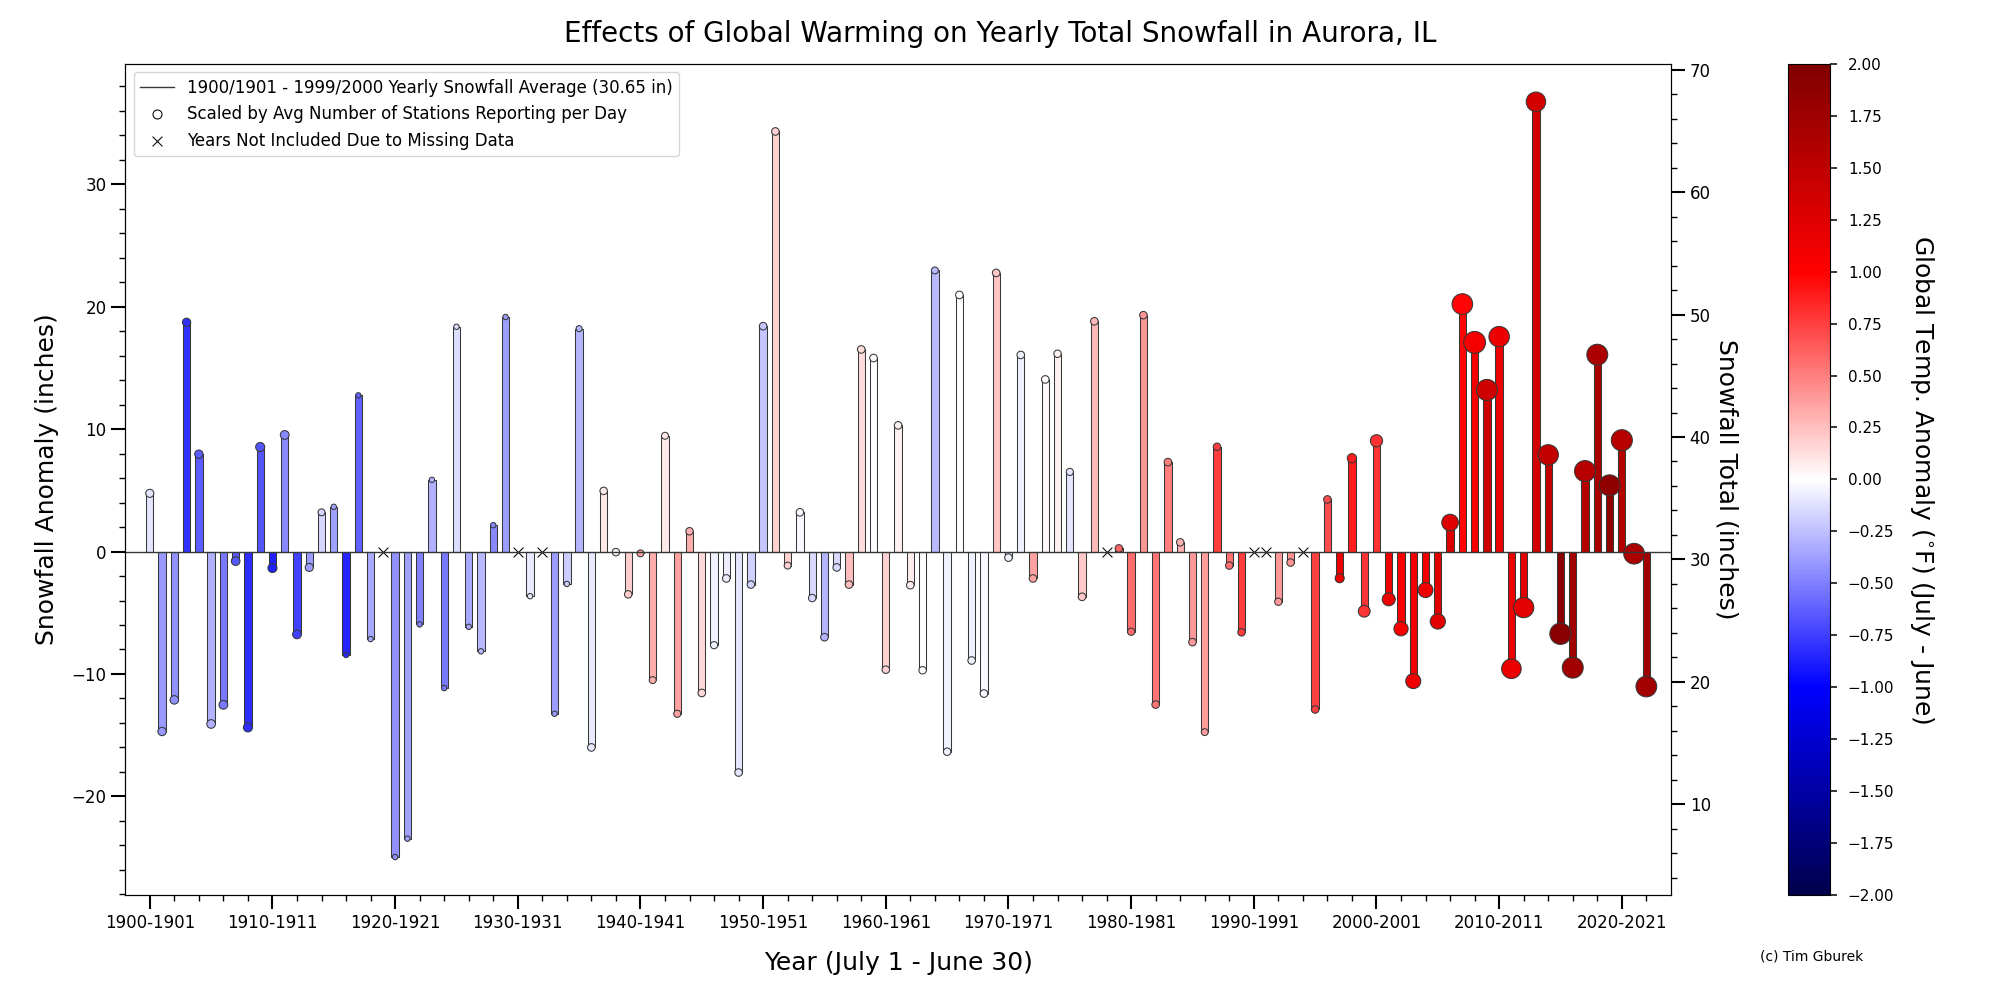

In [8]:
## Results are for the dataset where observations having the Measurement Flag "P" are included

decade  = 1900
decades = []

while decade != 2030:
    decades.append('{}-{}'.format(decade, decade+1))
    decade += 10
    
fig, ax = plt.subplots(figsize=(20,10))

cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=-2., vmax=2.)

ax.bar(global_temp_anoms_final.index.get_level_values(0), snowfall_by_year_final['Snowfall Anomalies'], width=0.6,
       color=cmap(norm(global_temp_anoms_final['Temp Anomaly'])), edgecolor='xkcd:charcoal', linewidth=0.75)

ax.set_xticks(np.arange(0,130,10), labels=decades)
ax.set_xlim([-2, 124])
ax.minorticks_on()
ax.set_xticks(np.arange(0,124,2), minor=True)
ax.tick_params(which='major', length=10, width=1.5, labelsize=12)
ax.tick_params(which='minor', length=4, width=1.0)
ax.set_xlabel('Year (July 1 - June 30)', fontsize=18, labelpad=14)
ax.set_ylabel('Snowfall Anomaly (inches)', fontsize=18, labelpad=9)

ax1 = ax.twinx()

ax1.scatter(global_temp_anoms_final.index.get_level_values(0), snowfall_by_year_final['Total Snowfall'],
            c=global_temp_anoms_final['Temp Anomaly'], cmap=cmap, norm=norm, edgecolors='xkcd:charcoal',
            s=snowfall_by_year_final['Avg # Stations']*15, linewidths=0.75)

circle = mpl.lines.Line2D([], [], color='None', marker='o', markersize=6.5, markeredgecolor='black', markeredgewidth=0.75, 
                          label='Scaled by Avg Number of Stations Reporting per Day')

line = ax1.axhline(y = baseline_average, linestyle='-', linewidth=1., color='xkcd:charcoal', 
                   label='1900/1901 - 1999/2000 Yearly Snowfall Average ({:.2f} in)'.format(baseline_average))

xs = ax1.scatter(removed_years.index.get_level_values(0), [baseline_average]*len(removed_years),
                 marker='x', c='black', linewidths=0.75, s=50,
                 label='Years Not Included Due to Missing Data')

ax1.minorticks_on()
ax1.set_xticks(np.arange(0,124,2), minor=True)
ax1.tick_params(which='major', length=10, width=1.5, labelsize=12)
ax1.tick_params(which='minor', length=4, width=1.0)
ax1.set_ylabel('Snowfall Total (inches)', fontsize=18, labelpad=20, rotation=270)

ax1.legend(handles=[line, circle, xs], loc='upper left', fontsize=12)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax1, location='right', ticks=np.arange(-2.,2.25,0.25), pad=0.06)
cbar.ax.tick_params(width=1.1, length=5, labelsize=11, pad=8)
cbar.set_label('Global Temp. Anomaly ($^{\circ}$F) (July - June)', fontsize=18, labelpad=30, rotation=270)

plt.annotate('(c) Tim Gburek', [0.88, 0.04], xycoords='figure fraction', fontsize=10)

fig.suptitle('Effects of Global Warming on Yearly Total Snowfall in Aurora, IL', fontsize=20, y=0.98)

fig.tight_layout(rect=(0.01,0.01,1.08,1.))

fig.savefig('Effects_of_Global_Warming_on_Yearly_Total_Snowfall_in_Aurora_IL_Tim_Gburek.png')

<IPython.core.display.Javascript object>


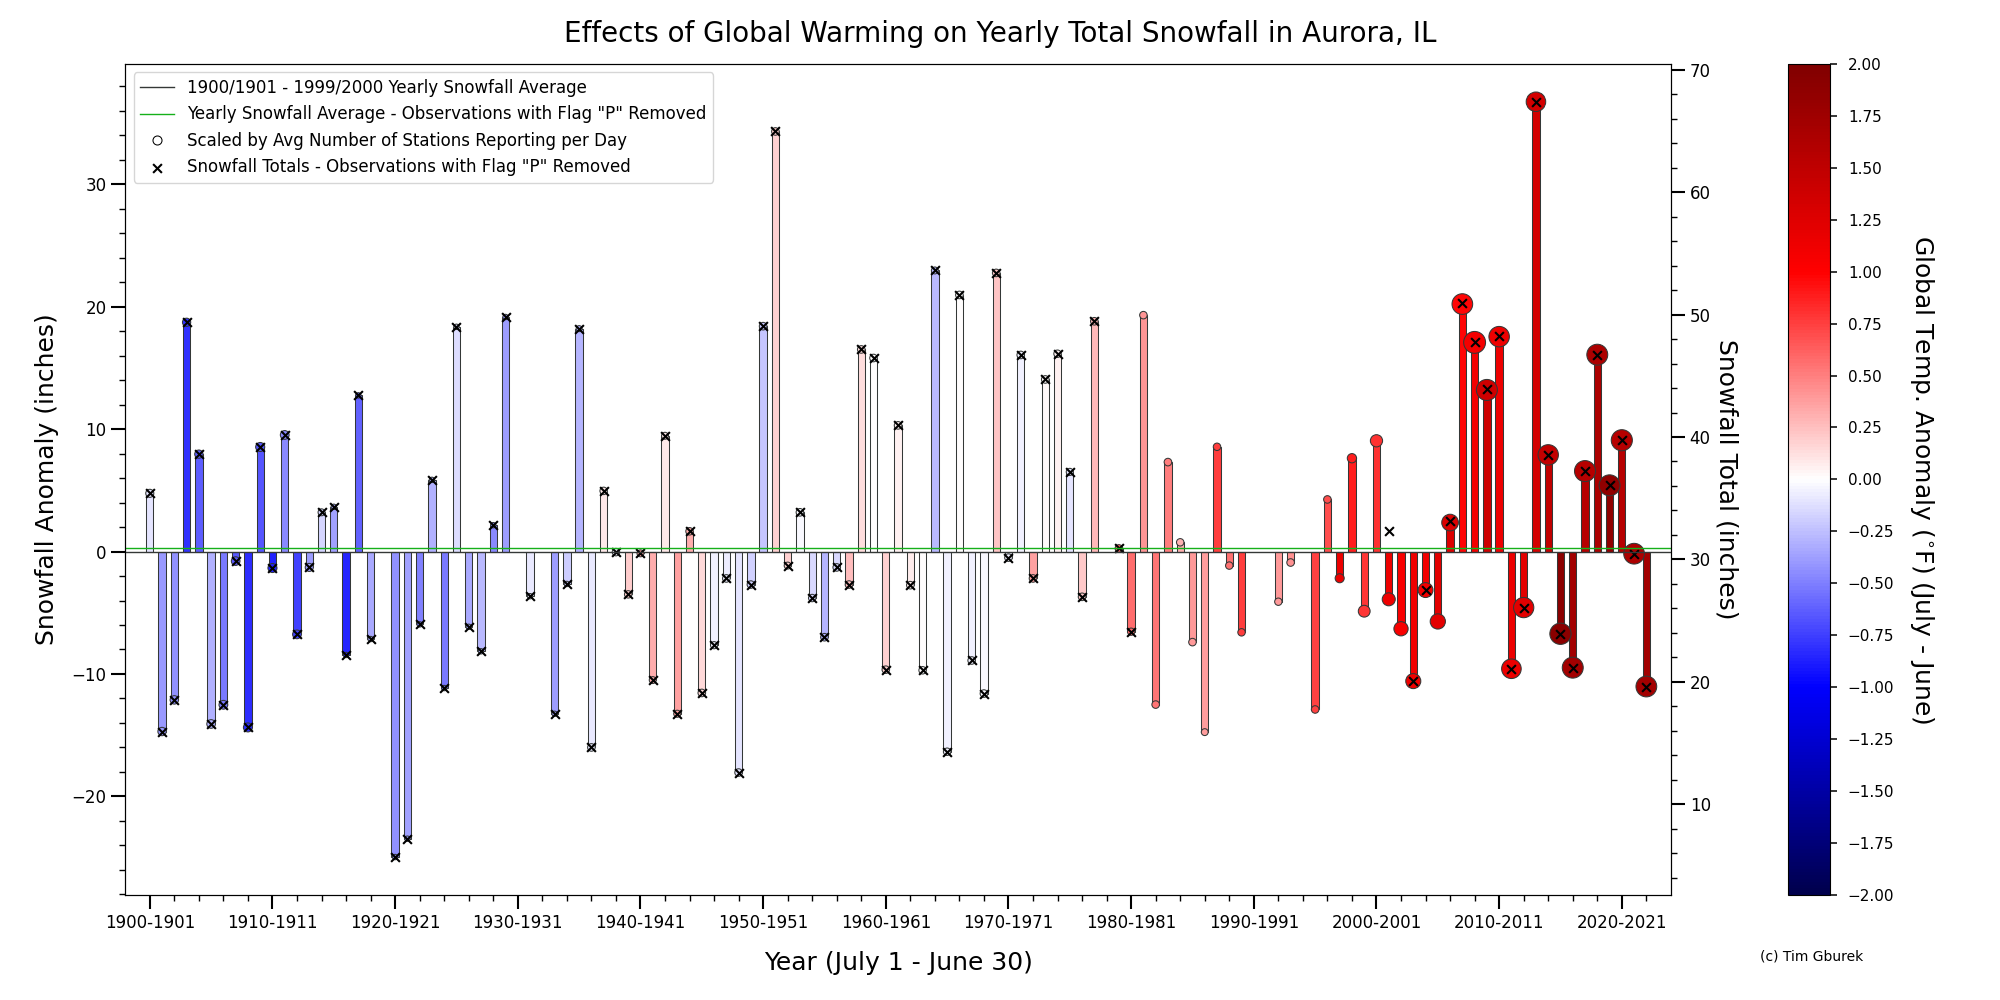

In [9]:
## Comparing results when observations flagged with the Measurement Flag "P" are included vs. excluded - Results are very similar.

decade  = 1900
decades = []

while decade != 2030:
    decades.append('{}-{}'.format(decade, decade+1))
    decade += 10
    
fig, ax = plt.subplots(figsize=(20,10))

cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=-2., vmax=2.)

ax.bar(global_temp_anoms_final.index.get_level_values(0), snowfall_by_year_final['Snowfall Anomalies'], width=0.6,
       color=cmap(norm(global_temp_anoms_final['Temp Anomaly'])), edgecolor='xkcd:charcoal', linewidth=0.75)

ax.set_xticks(np.arange(0,130,10), labels=decades)
ax.set_xlim([-2, 124])
ax.minorticks_on()
ax.set_xticks(np.arange(0,124,2), minor=True)
ax.tick_params(which='major', length=10, width=1.5, labelsize=12)
ax.tick_params(which='minor', length=4, width=1.0)
ax.set_xlabel('Year (July 1 - June 30)', fontsize=18, labelpad=14)
ax.set_ylabel('Snowfall Anomaly (inches)', fontsize=18, labelpad=9)

ax1 = ax.twinx()

ax1.scatter(global_temp_anoms_final.index.get_level_values(0), snowfall_by_year_final['Total Snowfall'],
            c=global_temp_anoms_final['Temp Anomaly'], cmap=cmap, norm=norm, edgecolors='xkcd:charcoal',
            s=snowfall_by_year_final['Avg # Stations']*15, linewidths=0.75)

circle = mpl.lines.Line2D([], [], color='None', marker='o', markersize=6.5, markeredgecolor='black', markeredgewidth=0.75, 
                          label='Scaled by Avg Number of Stations Reporting per Day')

line = ax1.axhline(y = baseline_average, linestyle='-', linewidth=1., color='xkcd:charcoal', 
                   label='1900/1901 - 1999/2000 Yearly Snowfall Average')


xs = ax1.scatter(global_temp_anoms_final_noP.index.get_level_values(0), snowfall_by_year_final_noP['Total Snowfall'],
            marker='x', color='black', s=40, label='Snowfall Totals - Observations with Flag "P" Removed')

line_noP = ax1.axhline(y = baseline_average_noP, linestyle='-', linewidth=1., color='xkcd:green', 
                       label='Yearly Snowfall Average - Observations with Flag "P" Removed')


ax1.minorticks_on()
ax1.set_xticks(np.arange(0,124,2), minor=True)
ax1.tick_params(which='major', length=10, width=1.5, labelsize=12)
ax1.tick_params(which='minor', length=4, width=1.0)
ax1.set_ylabel('Snowfall Total (inches)', fontsize=18, labelpad=20, rotation=270)

ax1.legend(handles=[line, line_noP, circle, xs], loc='upper left', fontsize=12)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax1, location='right', ticks=np.arange(-2.,2.25,0.25), pad=0.06)
cbar.ax.tick_params(width=1.1, length=5, labelsize=11, pad=8)
cbar.set_label('Global Temp. Anomaly ($^{\circ}$F) (July - June)', fontsize=18, labelpad=30, rotation=270)

plt.annotate('(c) Tim Gburek', [0.88, 0.04], xycoords='figure fraction', fontsize=10)

fig.suptitle('Effects of Global Warming on Yearly Total Snowfall in Aurora, IL', fontsize=20, y=0.98)

fig.tight_layout(rect=(0.01,0.01,1.08,1.))

fig.savefig('Effects_of_Global_Warming_on_Yearly_Total_Snowfall_in_Aurora_IL_wP_vs_noP.png')

In [10]:
## Map of weather stations used - orange markers represent stations with a Period of Record starting before 1997.
## All other stations began recording data in or after 1997.
## If you mouse-over the markers, you will see the Station Name, Station ID, Latitude, and Longitude

station_map = folium.Map(location=[41.78038, -88.30925], zoom_start=11)

for lat, long, ID, name in set(zip(snowfall_by_station['Latitude'], 
                                   snowfall_by_station['Longitude'], 
                                   snowfall_by_station['Station ID'], 
                                   snowfall_by_station['Station Name'])):
    
    if ((lat, long) == (41.65, -88.45)) or \
       ((lat, long) == (41.78038, -88.30925)) or \
       ((lat, long) == (41.9, -88.316667)) or \
       ((lat, long) == (41.8127, -88.0727)):
            
            folium.Marker((lat, long), icon=folium.Icon(color='orange'),
                          tooltip='Station Name: {}<br>Station ID: {}<br>Latitude: {}<br>Longitude: {}'.format(name, ID, lat, long)).add_to(station_map) ## HTML string
            
    else:
        folium.Marker((lat, long), tooltip='Station Name: {}<br>Station ID: {}<br>Latitude: {}<br>Longitude: {}'.format(name, ID, lat, long)).add_to(station_map)
    
display(station_map)